In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import pandas as pd
import time
from string import ascii_lowercase
from scipy import special
from scipy.constants import mu_0, epsilon_0
import empymod
# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import ElectricDipoleWholeSpace
from geoana.em.tdem import vertical_magnetic_flux_time_deriv_horizontal_loop
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from geoana.utils import ndgrid
from pymatsolver import Pardiso
# Machine Epssilon for float
import ipywidgets
eps = np.finfo(float).eps

C:\Users\81805\AppData\Local\Temp\ipykernel_26664\2124292880.py:15: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.electromagnetics import time_domain as tdem


In [2]:
tx_radius = (3.5)/(np.sqrt(np.pi))
print(f"Cell size: {tx_radius}")

Cell size: 1.9746635424171473


In [3]:
sigma_air = 1e-8
sigma_sea = 3.3
thick_sea = 1000.1
depth_seabed = 15.0
sigma_seabed = 1.0
sigma_target = 5.0
radius_target = 30.
height_target = 15.
slope_target = 3/5
depth_target = 15.
#tx_height = 0.5
tx_current = 1

In [4]:
csx, csz = tx_radius/4.,tx_radius/4.
ncx, ncz  = 100, 100 
# ncx, ncz  = 200, 200 
pf, npadx, npadz = 1.3 , 26, 26
mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, 2*ncz), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
print(f"Cell size: {csx}, number of cells in center: {ncx}")
tx_height = csx

Cell size: 0.4936658856042868, number of cells in center: 100


In [5]:
sigma_ref = {}
sigma_mound = {}
m = sigma_air * np.ones(mesh.n_cells)
m[mesh.cell_centers[:, 2] < thick_sea] = sigma_sea
sigma_ref = m.copy()
m[mesh.cell_centers[:, 2] < -depth_seabed - tx_height] = sigma_seabed
m[(mesh.cell_centers[:, 2] < -tx_height) & 
  (mesh.cell_centers[:, 2] > -tx_height - height_target - depth_target)  &
  ((mesh.cell_centers[:, 2] - (-tx_height -height_target)) < ( -slope_target * (mesh.cell_centers[:, 0] - radius_target))) &
  ((mesh.cell_centers[:, 2] - (-tx_height -height_target)) > (  slope_target * (mesh.cell_centers[:, 0] - radius_target)) )
] = sigma_target

sigma_mound = m

In [6]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  150)]
tstrt, tend = 1e-5, 1e-2

steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
time_clc = time_clc[time_clc < tend+eps ]

In [7]:
waveform=tdem.sources.StepOffWaveform()
rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, 0], times=time_clc, orientation="z"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_z],
    waveform=waveform, n_turns=5,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    t0=0,sigmaMap=maps.IdentityMap(mesh)
)


In [8]:
src.radius

1.9746635424171473

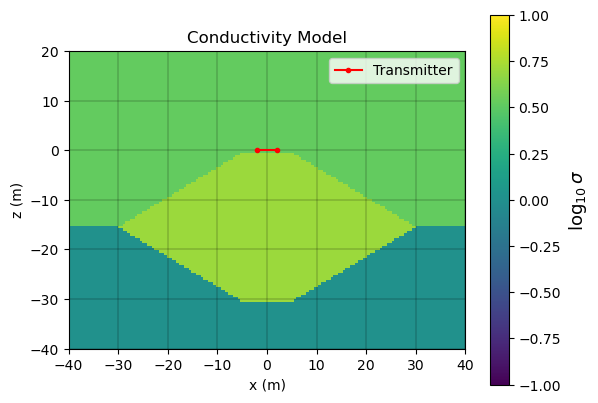

In [9]:
fig, ax = plt.subplots(1,1)
cb = plt.colorbar(mesh.plot_image(np.log10(sigma_mound), clim=[-1,1.0] ,ax=ax, mirror=True)[0])
    # plot the source locations and earth surface
ax.plot(np.r_[src.radius,-src.radius],np.r_[src.location[2],src.location[2]],"ro-", markersize=3,label="Transmitter")

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
#ax.axis('equal')
ax.set_xlim([-40., 40.])
ax.set_ylim([-40., 20.])
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.legend()
ax.grid(which='both', color='k', linestyle='-', linewidth=0.2)
ax.set_title('Conductivity Model');

In [10]:
fields_ref = sim.fields(sigma_ref)
fields_mound = sim.fields(sigma_mound)

## define some utility function for plotting

In [11]:
def plot_fields(model="reference", view="dbdt", time_ind=1,range_x=[-50., 50.], range_y=[-50., 50.], ax=None):
    min_field, max_field = None, None

    mirror_data=None
    v_type = "CC"
    view_type="real"    
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        
    if view in ["j", "dbdt"]:
        if model == "reference":
            plotme = fields_ref[src, view, time_ind]
        else:
            plotme = fields_mound[src, view, time_ind]
        max_field = np.abs(plotme).max() #use to set colorbar limits
        
        if view == "dbdt":
            v_type, view_type="F", "vec"
            cb_range = 5e2  # dynamic range of colorbar
            min_field = max_field/cb_range
            norm=LogNorm(vmin=min_field, vmax=max_field)
        elif view == "j":
            plotme = mesh.average_edge_y_to_cell * plotme
            mirror_data = -plotme
            norm=Normalize(vmin=-max_field, vmax=max_field)
    else:
        label = "$\sigma$"
        norm = LogNorm(vmin=0.1, vmax=5)
        if model == "reference":
            plotme = sigma_ref
        else:
            plotme = sigma_mound
    
    cb = plt.colorbar(mesh.plot_image(
        plotme, 
        v_type= v_type, view=view_type, mirror_data=mirror_data,
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts= {'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax,
    )[0], ax=ax)
    cb.set_label(view) 

 

In [12]:
def plot_mound_outline(ax,x_range=[-50., 50.]):
    x_mound_top= np.max(np.r_[0, radius_target- height_target/slope_target])
    x_mound_bot= np.max(np.r_[0, radius_target- depth_target/slope_target])
    x_mound= np.max(np.r_[0, radius_target/slope_target])

    x_top = np.r_[x_range[0],-radius_target,   -x_mound_top,   x_mound_top, radius_target, x_range[1]]
    z_top = np.r_[0         ,             0,  height_target, height_target,            0 ,          0] -tx_height-height_target
    x_bot = np.r_[x_range[0],-radius_target,   -x_mound_bot,   x_mound_bot, radius_target, x_range[1]]
    z_bot = np.r_[0         ,             0,  -depth_target, -depth_target,            0 ,          0] -tx_height-height_target
    ax.plot(x_top, z_top, color='k', alpha=0.5, lw=0.5)
    ax.plot(x_bot, z_bot, color='k', alpha=0.5, lw=0.5)
    return ax



In [13]:
def plot_fields_widgets(model="reference", view="dbdt", time_ind=1): 
    plt.clf()
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    plot_fields(model =model, view= view, time_ind=time_ind, ax=ax)
    # plot the outline of the mound
    if model == "mound":
        plot_mound_outline(ax)

    # plot the source locations 
    ax.plot(np.r_[src.radius,-src.radius],np.r_[src.location[2],src.location[2]],"ko-", markersize=3,label="Transmitter")
    ax.set_xlim([-40., 40.])
    ax.set_ylim([-40., 20.])
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')

    # give it a title
    ax.set_title(f'{view}, {sim.times[time_ind]*1e3:10.2e} ms')
    ax.set_aspect(1)
ipywidgets.interact(
    plot_fields_widgets, 
    model=ipywidgets.ToggleButtons(options=["reference", "mound"], value="reference"),
    view=ipywidgets.ToggleButtons(options=["model", "j", "dbdt"], value="model"),
    time_ind=ipywidgets.IntSlider(min=1, max=len(sim.time_steps)-1, value=1, continuous_update=False), 
);

interactive(children=(ToggleButtons(description='model', options=('reference', 'mound'), value='reference'), T…

In [14]:
def plot_two_fields(view="dbdt", time_ind=1,range_x=[-50., 50.], range_y=[-50., 50.], ax=None):
    min_field, max_field = None, None
    mirror_data_ref, mirror_data_mound=None, None
    v_type = "CC"
    view_type="real"    
    if ax is None: 
        fig, ax = plt.subplots(1,2, figsize=(8,5))
        
    if view in ["j", "dbdt"]:
        plotme_ref = fields_ref[src, view, time_ind]
        plotme_mound = fields_mound[src, view, time_ind]
        max_field = max(np.r_[abs(plotme_ref), abs(plotme_mound)]) #use to set colorbar limits
        
        if view == "dbdt":
            v_type, view_type="F", "vec"
            cb_range = 20  # dynamic range of colorbar
            min_field = max_field/cb_range
            norm=Normalize(vmin=min_field, vmax=max_field)

        elif view == "j":
            plotme_ref = mesh.average_edge_y_to_cell * plotme_ref
            plotme_mound = mesh.average_edge_y_to_cell * plotme_mound
            mirror_data_ref = -plotme_ref
            mirror_data_mound = -plotme_mound
            norm=Normalize(vmin=-max_field, vmax=max_field)

    else:
        label = "$\sigma$"
        plotme_ref = sigma_ref
        plotme_mound = sigma_mound
        norm = Normalize(vmin=sigma_seabed, vmax=sigma_target)
    
    cb = plt.colorbar(mesh.plot_image(
        plotme_ref, 
        v_type=v_type, view=view_type, mirror_data=mirror_data_ref,
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts={'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[0],
    )[0], ax=ax[0])
    cb.set_label(view) 

    cb = plt.colorbar(mesh.plot_image(
        plotme_mound, 
        v_type=v_type, view=view_type, mirror_data=mirror_data_mound,
        range_x=range_x, range_y=range_y,
        pcolor_opts={'norm': norm}, stream_opts={'color': 'w'}, 
        stream_threshold=min_field, mirror=True, ax=ax[1],
    )[0], ax=ax[1])
    cb.set_label(view) 

    return ax

In [15]:
def plot_two_fields_widgets(view="dbdt", time_ind=1): 
    plt.clf()
    fig, ax = plt.subplots(1,2, figsize=(11,4))

    plot_two_fields(view= view, time_ind=time_ind,range_x=[-40., 40.], range_y=[-40., 20.],ax=ax)
    # plot the outline of the mound
    plot_mound_outline(ax[1])

    # plot the source locations
    for a in ax:
        a.plot(np.r_[src.radius,-src.radius],np.r_[src.location[2],src.location[2]],"ko-", markersize=3,label="Transmitter")
        # a.set_xlim([-40., 40.])
        # a.set_ylim([-40., 20.])
        a.set_aspect('equal')
        a.set_xlabel('x (m)')
        a.set_ylabel('z (m)')  
        a.set_title(f'{view}, {sim.times[time_ind]*1e3:10.2e} ms')
        a.set_aspect(1)   
    plt.tight_layout()

ipywidgets.interact(
    plot_two_fields_widgets, 
    view=ipywidgets.ToggleButtons(options=["model", "j", "dbdt"], value="model"),
    time_ind=ipywidgets.IntSlider(min=1, max=len(sim.time_steps)-1, value=1, continuous_update=False), 
);

interactive(children=(ToggleButtons(description='view', options=('model', 'j', 'dbdt'), value='model'), IntSli…

<Figure size 640x480 with 0 Axes>

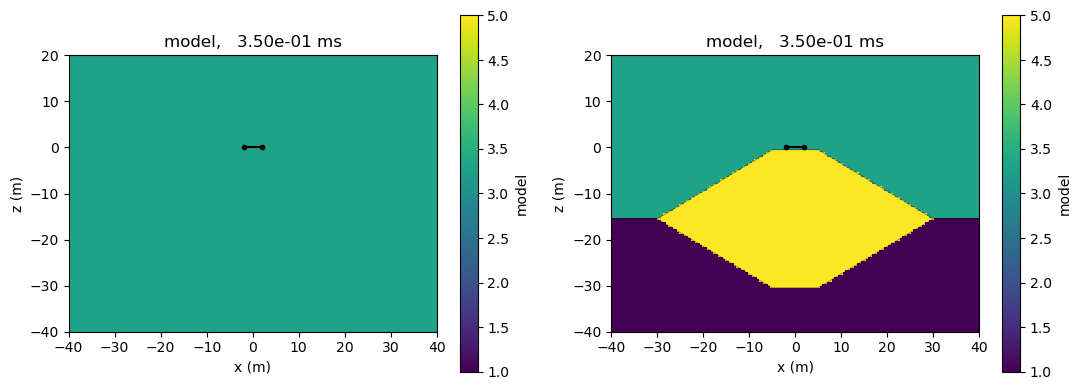

In [16]:
plot_two_fields_widgets(view="model", time_ind= 160)
plt.savefig("24_PlotFields_mound_model.png", dpi=200, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

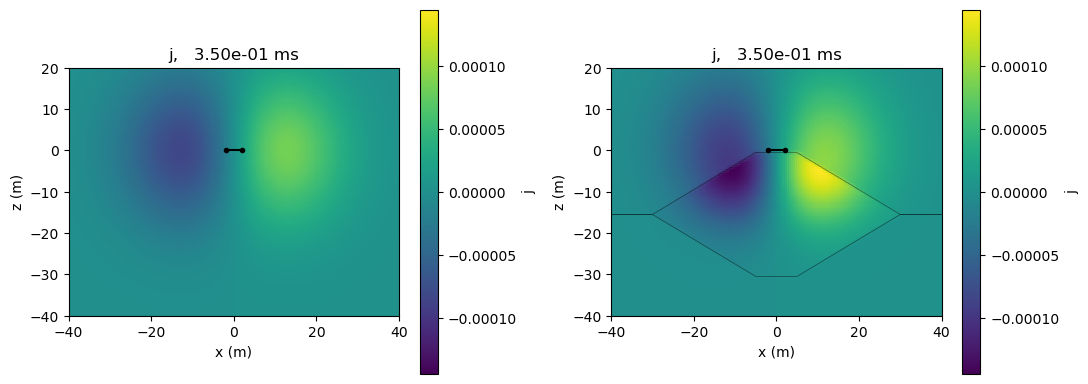

In [17]:
plot_two_fields_widgets(view="j", time_ind= 160)
plt.savefig("24_PlotFields_mound_j.png", dpi=200, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

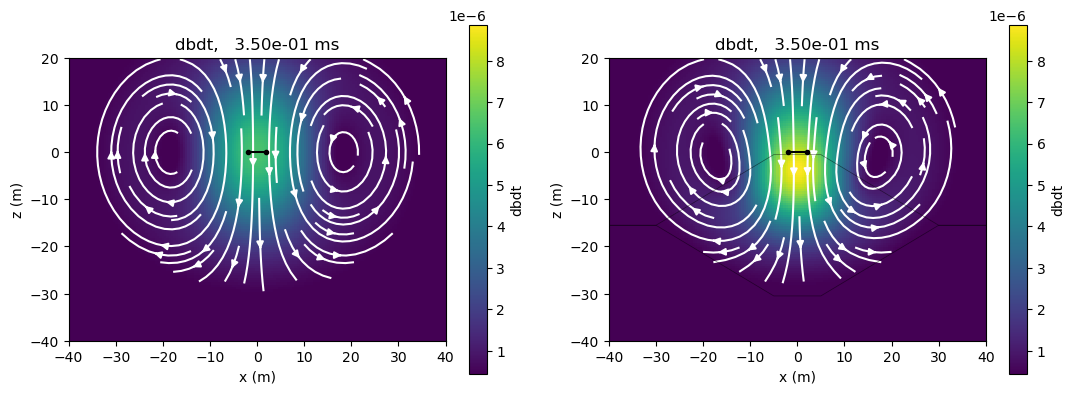

In [18]:
plot_two_fields_widgets(view="dbdt", time_ind= 160)
plt.savefig("24_PlotFields_mound_dbdt.png", dpi=200, bbox_inches='tight')